# Imports

In [1]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import warnings
from IPython.display import clear_output

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from scipy.sparse import csr_array

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

# Configuration

In [2]:
# PREVIEW PHASE
PREVIEW_REVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True

# PREPROCESS IMAGES PHASE
PREPROCESS_IMAGES = True

# SAMPLINg
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)
sns.set()

# Fonctions

In [3]:
def time_from(time_start):
    time_total = round(time.time() - time_start, 0)
    minutes = time_total // 60
    seconds = time_total - minutes * 60
    return f'{minutes:.0f}mn {seconds:.0f}s'
    
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

# Extractions des sujets des reviews

## Prévisualiastions des datasets

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
408,Rz0KfP7YAZV_yQE8uIB0fg,El Sabor Boricua,11612 N Nebraska Ave,Tampa,FL,33612,28.053515,-82.453442,5.0,6,0,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Puerto Rican, Caribbean, Latin American, Resta...","{'Wednesday': '11:0-15:0', 'Thursday': '11:0-1..."
570,00szsg8vQy6yX5f-m9sI4A,None Such Farm Market,4458 York Rd,Buckingham,PA,18912,40.318620,-75.066274,4.0,36,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Grocery, Food, Farmers Market","{'Wednesday': '10:0-18:0', 'Thursday': '10:0-1..."
660,kLSEk3qXY1KdtFjxHJ9pww,McDonald's,501 Franklin Mill Cir,Philadelphia,PA,19154,40.088416,-74.965011,1.5,20,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Fast Food, Food, Coffee & Tea, Bu...","{'Monday': '5:30-0:0', 'Tuesday': '5:30-0:0', ..."
958,fVPPZWf5QghlCLYRYec1rg,China Sunrise Restaurant,"6878 E Sunrise Dr, Ste 120",Tucson,AZ,85750,32.308830,-110.845497,3.5,12,0,"{'NoiseLevel': 'u'quiet'', 'RestaurantsPriceRa...","Restaurants, Chinese",None
213,ZU6NodDOWaabGkeNpOWdXw,530 Pub & Grill,530 Cleveland St,Clearwater,FL,33755,27.965747,-82.798901,4.5,6,1,"{'WheelchairAccessible': 'True', 'RestaurantsT...","American (Traditional), Restaurants, Burgers, ...","{'Tuesday': '11:0-23:0', 'Wednesday': '11:0-23..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
553,-FYgaeBm9xNhF4_m8bCC0A,"2010-05-14 19:46:24, 2010-09-21 17:30:50, 2010..."
628,-I7M6l0h46VdiN09Y1NUZw,"2019-06-29 01:29:44, 2019-07-06 20:03:34, 2019..."
337,-8wxCs5UMpo5vkutnwHmbA,"2010-08-23 01:43:30, 2011-04-02 15:21:37, 2012..."
657,-J0RIXNexJDV-mOAyhUJIQ,"2012-10-20 12:29:45, 2012-10-23 04:23:49, 2012..."
92,-1b7CQbbl_3uotcTsxhHsw,"2011-04-21 20:22:02, 2011-11-25 20:33:43, 2012..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
682,MSZuaItS46OO_47XmktjcQ,BO1xi6vjg46qcwIfJDGIAg,kGNzqiYKDns-IU80uHF4sw,3,0,0,0,I had chicken BBQ burritos with all kinds of s...,2014-09-25 15:08:18
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
573,pIFGqL210EybhN6t0Jtzjw,DB5uuOamJ5N2RZ5ylqOFQw,OfI4DC1DVCJ92XcLdFBMFg,4,0,0,0,I really enjoy this theater! It is always clea...,2018-07-17 16:13:00
130,LnKr0hwejzl71QmoQyTRDQ,7RU_xK1tEGlUvXfe0GvtEg,hAmuto6UndVroyd_DaD-TA,5,1,0,0,Not sure why it took until now for us to find ...,2018-03-04 00:20:24
246,Zb_27vX8weaYyDn-_2ZhVA,5C_C7bd6rZYgiP4puQxESQ,0Kn5W22UmxOqPj2cjouFNA,1,1,1,0,This is an updated review. I've been ordering ...,2015-10-08 04:32:10


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
895,SoW_wiVR03AzjhjOyXT-ew,mUIBtlWNPD7sz3rGGWQ1RA,Yum yum yum Cypress Breakfast here I come!,2012-01-08 16:45:27,0
441,XTraoWA-NVwt2KLd8rdfOg,nn5tvvgFtnoyCocACvXmJQ,Amazing Brunch!!!,2010-12-05 19:31:47,0
431,TKhIqy7LgMYSwE2mah7lGA,TFy1mR2ip4QTdKFq9JfV1A,This place is actually open until 10 pm not 9.,2015-05-27 01:09:02,0
86,gHUJQESZY_UESjTxh0HpOw,-CRjqZ4GxZ6lIa_qMj7-yw,Solid late night Chinese take out,2017-03-18 03:43:34,0
996,32YFFu5OSBg_rimVyoITRw,V5wqGto1Lyv_CUdoRsfCwA,They are now out of business. Too bad!,2015-01-13 03:23:03,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
766,Hjfbo7zwpCI5CI5OjkGMqw,Eira,301,2011-06-27 22:28:20,740,188,297,"2012,2013,2014,2015","qpFCY_wj8_G-HOV8MxIaHw, Xw7ZjaGfr0WNVt6s_5KZfA...",12,...,10,0,0,3,24,25,40,40,30,1
360,NWFqEfs5Z9wUmCeVfTTDAA,David,16,2008-12-26 14:34:35,11,2,7,,"IpYw-Ygpoo9gI4s-Mwrc1g, lzkgEU64tgQwUI_J423LUQ...",1,...,1,0,0,0,0,1,0,0,0,0
689,UYUWmXsUynm4sTkwk9siZw,Chris,327,2008-03-14 14:41:58,1677,1588,1213,"2008,2009,2010,2011,2012,2013","e2L85lk-lIGkCNn6F-qPhw, 2RcxsD8CTzKEFtArNp5SDQ...",69,...,18,5,8,11,101,164,221,221,55,19
663,gf4tyQgQOtVMkOdvveRHVA,Henry,1512,2008-02-05 18:06:36,2895,1382,1704,2008,"ojUhl1c73aE0JVBt7ud5PQ, 6JZnwT0rGocZ1Y_LyIWIJA...",64,...,16,10,26,2,134,559,357,357,68,16
826,zdw1jwmw1TNLZgu_is_Seg,Pam,108,2011-03-21 03:27:57,214,52,85,"2011,2012,2013","fwOSFdqvyvG4B-jNaseceQ, 0ED7A-Tae6OKYL1hkD4tSA...",8,...,0,0,1,0,15,2,18,18,5,2


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

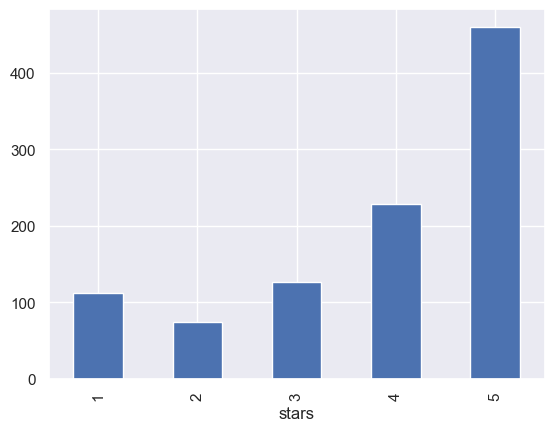

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [8]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

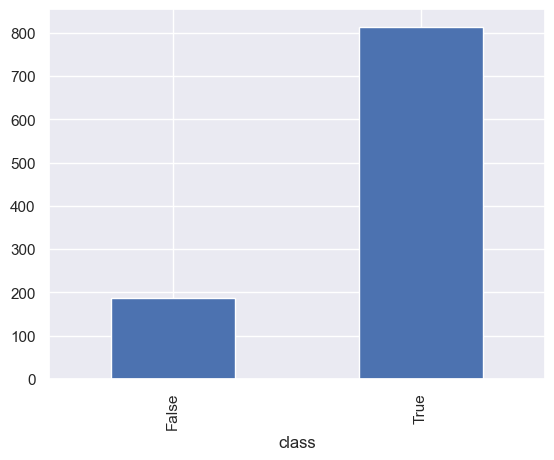

In [9]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 2
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [10]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]

## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [11]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

146883                               [Restaurants, Chinese]
58517                          [Beauty & Spas, Hair Salons]
79003                  [Fast Food, Restaurants, Sandwiches]
21526     [Local Services, Handyman, Home Services, Move...
13083     [Eyewear & Opticians, Accessories, Shopping, F...
Name: _cats, dtype: object

In [12]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [13]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurants', 'Restaurant Supplies', 'Pop-Up Restaurants']

In [14]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Fast Food',
 'Food Banks',
 'Comfort Food',
 'Imported Food',
 'Seafood',
 'Live/Raw Food',
 'Do-It-Yourself Food',
 'Soul Food',
 'Food Court',
 'Ethnic Food',
 'Food Trucks',
 'Food Delivery Services',
 'Seafood Markets',
 'Food Tours',
 'Specialty Food',
 'Food',
 'Food Stands']

### Création des fichiers parquets

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité

In [15]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [16]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [17]:
get_reviews(max_stars=1).dtypes

review_id                 object
user_id                   object
business_id               object
stars                      int64
useful                     int64
funny                      int64
cool                       int64
text                      object
date              datetime64[ns]
name                      object
address                   object
city                      object
state                     object
postal_code               object
latitude                 float64
longitude                float64
stars_business           float64
review_count               int64
is_open                    int64
attributes                object
categories                object
hours                     object
_cats                     object
review_count_q            object
dtype: object

## Analyse des echantillons de reviews 

### Nuages de mots par note

In [18]:
def review_word_cloud(reviews, no_below = 4, no_above = 0.1, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')
    
    sample_text = ' '.join(sample.str.join(' ').values)
    word_cloud(text=sample_text)
    print('')

Note = 5


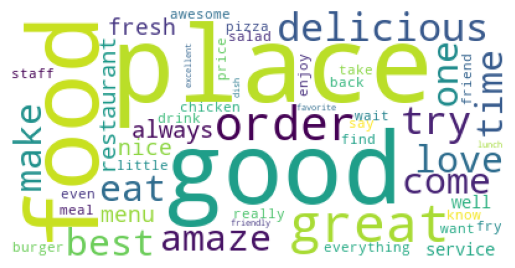


Note = 4


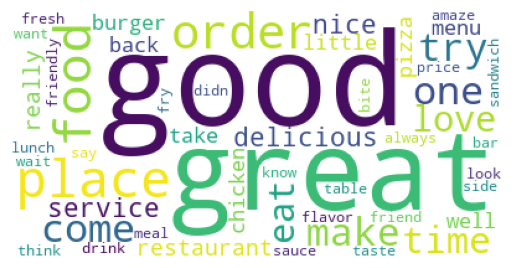


Note = 3


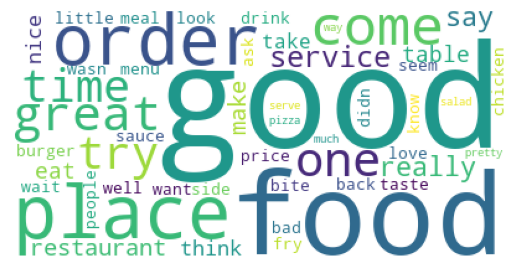


Note = 2


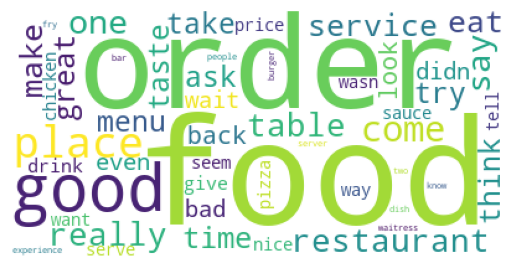


Note = 1


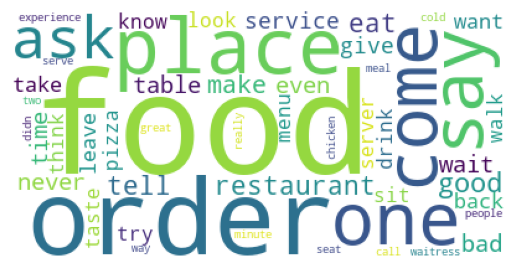

In [19]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    review_word_cloud(reviews=get_reviews(stars=stars),
                      no_below=2,
                      no_above= 0.3)

### Sac de mots (TF-IDF) et visualisation (PCA/TSNE)

In [20]:
def tf_idf(reviews, min_df = 4, max_df = 100, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words="english", sublinear_tf=True,ngram_range=(1,2))
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

In [21]:
reviews = get_reviews(max_stars=2)
tf_idf(reviews=reviews,
       min_df=10,
       max_df=0.1,
       verbose=1)

Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


,100,1st,2nd,able,absolute,absolutely,accept,accommodate,acknowledge,act,...,yell,yelp,yes,yesterday,york,young,yuck,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.262554,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.212173,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.3480           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | attention: 0.2933        |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | cash: 0.3238             |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | close: 0.2257            |
|                                                                           

## Recherche des sujets d'insatisfactions

### LDA / NMF Librairie Sklean

In [22]:
def get_topics(reviews: pd.DataFrame, model = 'lda', min_df = 4, max_df = 10, n_topics = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    if verbose > 1: print('  - Vectorisation (tf-idf)')
    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    # Topics from LDA or MDF
    if model == 'lda':
        if verbose > 1: print('  - Modélisation LDA')
        model = LatentDirichletAllocation(n_components=n_topics,
                                          max_iter=10, 
                                          learning_method='online', 
                                          learning_offset=10,
                                          random_state=0,
                                          n_jobs=-1)
    if model == 'nmf':
        if verbose > 1: print('  - Modélisation NMF')
        model = NMF(n_components=n_topics, 
                    random_state=0,)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    return topics
    
def find_topics(reviews, model = 'lda', min_df = 4, max_df = 100, n_topics = 10, n_topic_top_words=10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)

    topics = get_topics(reviews, model = model, min_df = 4, max_df = 100, n_topics=n_topics, n_top_words=n_topic_top_words, ngram_range=ngram_range, verbose=verbose)

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)
    
    return topics

In [24]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     model='lda',
                     min_df=2,
                     max_df=0.1,
                     n_topics=15, 
                     n_topic_top_words=5,
                     ngram_range=(1,1),
                     verbose=3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  -----------------------------------------------------
         0  donut, dunkin, idk, idiot, sport
         1  anniversary, constantly, chorizo, sausage, atmosphere
         2  interior, highly, bore, third, tasteless
         3  dance, song, bother, totally, overall
         4  ball, coke, crab, hop, desk
         5  beer, roll, breakfast, taco, sushi
         6  iceberg, boot, overflow, wow, refund
         7  afterwards, real, parm, delivery, breakfast
         8  scar, scary, crack, ive, twice
         9  miss, item, include, utensil, starve
        10  ramen, instant, deliver, soup, loud
        11  beer, freeze, burrito, gyro, mom
        12  tex, mex, deli, wawa, life
        13  meatloaf, tough, roll, hungry, season
        14  bubble, trick, pearl, hat, juicy


In [25]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     model='nmf',
                     min_df=2,
                     max_df=0.1,
                     n_topics=5, 
                     n_topic_top_words=5,
                     ngram_range=(2,3),
                     verbose=3)

  - Vectorisation (tf-idf)
  - Modélisation NMF
  - Affichage des topics

  Topic n°  Categories
----------  -----------------------------------------------------------------------------------
         0  not good, food not, much good, not very, very good
         1  win back, try place, food price, good food, food time
         2  would not, not recommend, would not recommend, recommend place, not recommend place
         3  get food, take minute, customer service, wait minute, first time
         4  very disappoint, look like, saturday even, taco bell, nothing special


### LDA Librairie Gensim et optimisation du nombre de sujets

In [31]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=2)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, num_topics = 10):
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def search_best_model(dictionary, corpus, texts, limit, start=2, step=1):
    coherences = []
    models = []
    topics_range = range(start, limit, step)
    for num_topics in topics_range:
        print(f'  - Test pour {num_topics} topics', end='\r')
        model = modelize(dictionary=dictionary, corpus=corpus, num_topics=num_topics)
        models.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(coherence_model.get_coherence())

    argmax = np.array(coherences).argmax()
    best_model = models[argmax]
    print(f'  - Meilleur model trouvé avec {best_model.num_topics} topics')
    
    plt.plot(topics_range, coherences)
    plt.show()
    
    return best_model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

  - Préparation des data (preprocess tokenisation...)
  - Meilleur model trouvé avec 2 topics


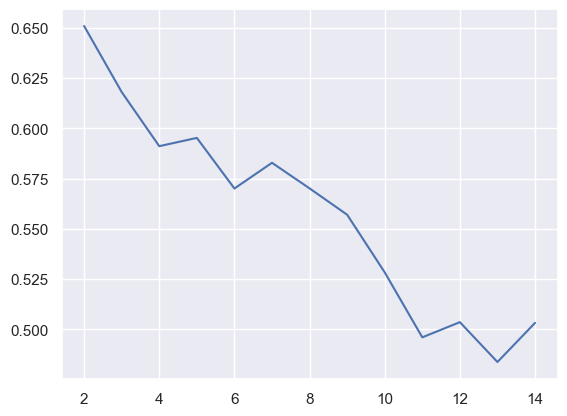

+------------+------------------+
|   Topic n° | mots clés        |
+============+==================+
|          1 | 0.006*"sauce"    |
|            | 0.005*"cheese"   |
|            | 0.005*"salad"    |
|            | 0.005*"pizza"    |
|            | 0.004*"burger"   |
|            | 0.004*"sandwich" |
|            | 0.004*"flavor"   |
|            | 0.004*"cook"     |
|            | 0.003*"dish"     |
|            | 0.003*"side"     |
+------------+------------------+
|          2 | 0.005*"bar"      |
|            | 0.005*"walk"     |
|            | 0.005*"seat"     |
|            | 0.005*"waitress" |
|            | 0.004*"call"     |
|            | 0.004*"manager"  |
|            | 0.004*"check"    |
|            | 0.003*"waiter"   |
|            | 0.003*"bring"    |
|            | 0.003*"friend"   |
+------------+------------------+


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.097149  0.0       1        1  51.224626
0     -0.097149  0.0       2        1  48.775374, topic_info=            Term        Freq       Total Category  logprob  loglift
88         sauce  579.000000  579.000000  Default  30.0000  30.0000
43        cheese  472.000000  472.000000  Default  29.0000  29.0000
330        salad  471.000000  471.000000  Default  28.0000  28.0000
1572      flavor  367.000000  367.000000  Default  27.0000  27.0000
505         walk  488.000000  488.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
54    everything  213.760599  290.045875   Topic2  -6.1097   0.4128
623       pretty  232.428037  414.863761   Topic2  -6.0260   0.1386
142      nothing  229.500544  399.358803   Topic2  -6.0387   0.1640
188          use  222.629841  454.246021   Topic2  -6.0691   0.0048
381         ever  213.791499  399.052495   Topic2  -6.1096   0.0939

[163 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
753       1  0.990336  acknowledge
1976      1  0.987423          act
1611      1  0.973524        allow
1611      2  0.024338        allow
3185      1  0.991722       answer
...     ...       ...          ...
750       2  0.964527         wing
936       1  0.769418         work
936       2  0.231107         work
2182      1  0.981242         yell
2182      2  0.022301         yell

[254 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [34]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1)
best_model = search_best_model(dictionary=dictionary, corpus=corpus, texts=texts, limit=15, start=2, step=1)
print_topics(best_model)
vis = visualize_model(best_model, corpus, dictionary)
vis

# Classifications des images

## Prévisualisation du dataset

In [79]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

,photo_id,business_id,caption,label
2430,W3JdJWhlCCP3ZOeT_CVajg,cVZ4whFwPNA721C4DIetbg,,food
160905,E46MjuGjlbL-k5ZBgMvVIw,fEbDHX6ecBAuZfaJ7hFzgw,,food
43534,bEKKO0-YVq2bz0_Gq8GcTA,oS70RVt-RegY3Ts0hLASQA,Pad Thai Shrimp,food
194724,ZBufONuwV2AviUU6--ewcA,qltayRFPZ1GiSMeUkeF3Dw,,inside
132725,r2UNNl445YKBm86Df_Bj0g,3rRESenaBw-AyT0Jt7eJNg,The downstairs bar,inside


In [80]:
df_photos.shape

(200100, 4)

In [81]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

In [82]:
photo_ids = []
for label in df_photos.label.unique():
    photo_ids = photo_ids + list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])

df_photos_sampling = pd.DataFrame({'photo_id': photo_ids, 'width': np.zeros(len(photo_ids)), 'height': np.zeros(len(photo_ids)), 'mode': np.full(len(photo_ids), '')})

In [91]:
def fill_infos(df):
    for index in df.index:
        print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.head()

,photo_id,width,height,mode
0,4bCgKE0Itp0T8wQXpYsypg,458.0,400.0,RGB
1,RN1AVvw1HXLceaNJkI0GdQ,300.0,400.0,RGB
2,XDVvq4N-wZV5jKVSUYXI2Q,300.0,400.0,RGB
3,IBCtJNh1XJApQSCSzLznlw,533.0,400.0,RGB
4,XIiiz9u9TY5CWjWlUW4pOg,533.0,400.0,RGB


In [84]:
df_photos_sampling.describe()

,width,height
count,500.000000,500.000000
mean,438.882000,389.688000
std,131.985303,32.814085
min,131.000000,69.000000
25%,300.000000,400.000000
50%,408.000000,400.000000
75%,543.750000,400.000000
max,600.000000,400.000000


In [85]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Pretraitement des images

In [101]:
def preprocess_images(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image(photo_id)

def preprocess_image(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img)

    if display_evo:
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
     # Apply gaussian blur
    img = img.filter(ImageFilter.GaussianBlur(radius=1))
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + filename
    img.save(new_path)

    return new_path

### Exemple de pre-traitement

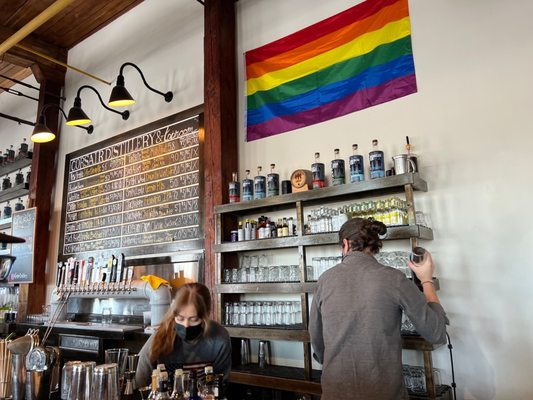

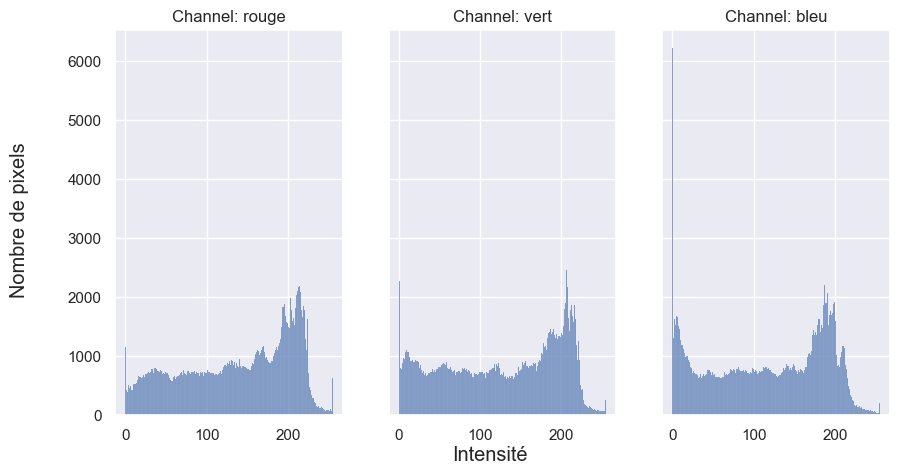

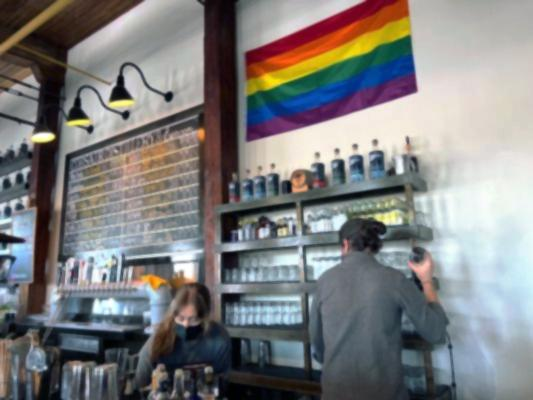

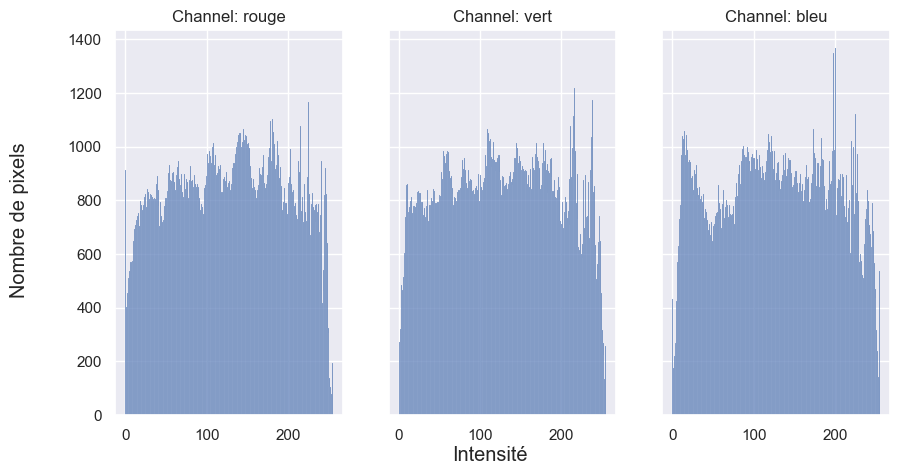

'data/work/yelp_photos/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [102]:
photo_id_sample = df_photos_sampling.sample(1, random_state=0)['photo_id'].iloc[0]
preprocess_image(photo_id_sample,display_evo=True)

### Pretaitement de l'ensemble de l'échantillon

In [103]:
if PREPROCESS_IMAGES:
    preprocess_images(df=df_photos_sampling)